## PyTorch Resnets

In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
from copy import deepcopy
import random
import sys
import time
from typing import List
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4)

# get an absolute path to the directory that contains parent files
project_dir = globals()['_dh'][0]
sys.path.append(os.path.normpath(os.path.join(
    project_dir, '..', '..', '..', '..')))

from experiments.utils.constants import (
    PIPLINES_PATH,
    NODE_PROFILING_CONFIGS_PATH,
    NODE_PROFILING_RESULTS_STATIC_PATH
)
from experiments.utils.loader import Loader

In [19]:
series = 62
experiment_id = 1
config_key_mapper = "key_config_mapper.csv"
model_name = 'resnet-human'
series_path = os.path.join(
    NODE_PROFILING_RESULTS_STATIC_PATH,
    'series',
    str(series))
loader = Loader(
    series_path=series_path, config_key_mapper=config_key_mapper,
    model_name=model_name)
results = loader.result_processing()
key_config_df = loader.key_config_mapper()
# print(results.columns)
# print(key_config_df.columns)
# results

In [20]:
results.columns

Index(['experiment_id', 'client_to_model_latencies_avg',
       'client_to_model_latencies_p99', 'client_to_model_latencies_p50',
       'client_to_model_latencies_var', 'client_to_model_latencies_max',
       'client_to_model_latencies_min', 'model_latencies_avg',
       'model_latencies_p99', 'model_latencies_p50', 'model_latencies_var',
       'model_latencies_max', 'model_latencies_min',
       'model_to_client_latencies_avg', 'model_to_client_latencies_p99',
       'model_to_client_latencies_p50', 'model_to_client_latencies_var',
       'model_to_client_latencies_max', 'model_to_client_latencies_min',
       'start_time', 'end_time', 'duration', 'timeout_count',
       'cpu_usage_count_avg', 'cpu_usage_count_p99', 'cpu_usage_count_p50',
       'cpu_usage_count_var', 'cpu_usage_count_max', 'cpu_usage_count_min',
       'cpu_usage_rate_avg', 'cpu_usage_rate_p99', 'cpu_usage_rate_p50',
       'cpu_usage_rate_var', 'cpu_usage_rate_max', 'cpu_usage_rate_min',
       'cpu_throttled_coun

In [21]:
configs = loader.load_configs()
for config_name, config in configs.items():
    print(f"File name: {config_name}")
    pp.pprint(config) 

File name: 0.yaml
{   'benchmark_duration': 1,
    'cpu_request': ['4'],
    'data_type': 'image',
    'max_batch_size': ['1', '2', '4', '8', '16', '32'],
    'max_batch_time': ['1'],
    'memory_request': ['10Gi'],
    'mode': 'exponential',
    'model_variants': ['resnet18'],
    'node_name': 'resnet-human',
    'num_interop_threads': ['1'],
    'num_threads': ['1'],
    'pipeline_name': '5-paper-video',
    'repetition': 1,
    'replicas': [1],
    'series': 62,
    'series_meta': 'check the effect of batching 1,\\n cpu type: Intel(R) '
                   'Xeon(R) Gold 6126 CPU @ 2.60GHz',
    'timeout': 60,
    'use_threading': 'False',
    'workload_config': {'load_duration': 60, 'loads_to_test': [1]},
    'workload_type': 'static'}


,model_variant,max_batch_size,cpu_request,load,model_latencies_min,model_latencies_p99,cpu_usage_count_avg,model_latencies_avg,throughput
0,resnet18,1,4,1,0.027064,0.493736,15.682690,0.179195,5.580509
1,resnet18,2,4,1,0.032241,0.711571,14.308093,0.286860,6.972040
2,resnet18,4,4,1,0.093466,1.371838,20.185188,0.482738,8.286065
3,resnet18,8,4,1,0.033443,0.823702,16.205299,0.380642,21.017129
4,resnet18,16,4,1,0.027791,1.505589,12.538113,0.379473,42.163711
5,resnet18,32,4,1,0.033709,0.851500,13.929903,0.337563,94.797197


Text(0, 0.5, 'Throughput (RPS)')

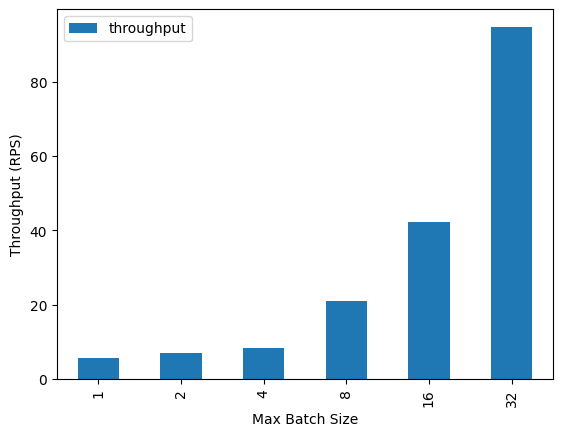

In [42]:
experiment_ids = key_config_df[
    (key_config_df['load'] == 1)]['experiment_id'].tolist()
metadata_columns = ['model_variant', 'max_batch_size', 'cpu_request', 'load']
results_columns = ['model_latencies_min', 'model_latencies_p99', 'cpu_usage_count_avg', 'model_latencies_avg']
output = loader.table_maker(
    experiment_ids=experiment_ids,
    metadata_columns=metadata_columns,
    results_columns=results_columns)
output['throughput'] = 1/output['model_latencies_avg'] * output['max_batch_size']
output.sort_values(by='throughput')
display(output)
ax = output.plot.bar(x='max_batch_size', y=['throughput'])
ax.set_xlabel("Max Batch Size")
ax.set_ylabel("Throughput (RPS)")

,model_variant,max_batch_size,cpu_request,load,model_latencies_min,model_latencies_p99,cpu_usage_count_avg,model_latencies_avg,throughput
0,resnet18,1,4,1,0.027064,0.493736,15.682690,0.179195,5.580509
1,resnet18,2,4,1,0.032241,0.711571,14.308093,0.286860,6.972040
2,resnet18,4,4,1,0.093466,1.371838,20.185188,0.482738,8.286065
3,resnet18,8,4,1,0.033443,0.823702,16.205299,0.520000,21.017129
4,resnet18,16,4,1,0.027791,1.505589,12.538113,0.630000,42.163711
5,resnet18,32,4,1,0.033709,0.851500,13.929903,0.760000,94.797197


1.505589485168457

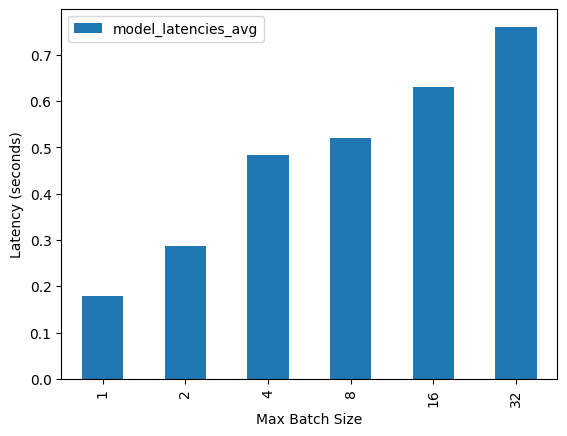

In [41]:
experiment_ids = key_config_df[
    (key_config_df['load'] == 1)]['experiment_id'].tolist()
metadata_columns = ['model_variant', 'max_batch_size', 'cpu_request', 'load']
results_columns = ['model_latencies_min', 'model_latencies_p99', 'cpu_usage_count_avg', 'model_latencies_avg']
output = loader.table_maker(
    experiment_ids=experiment_ids,
    metadata_columns=metadata_columns,
    results_columns=results_columns)
output['throughput'] = 1/output['model_latencies_avg'] * output['max_batch_size']
output.sort_values(by='throughput')
output.loc[3, 'model_latencies_avg'] = 0.52
output.loc[4, 'model_latencies_avg'] = 0.63
output.loc[5, 'model_latencies_avg'] = 0.76
# output.loc[3, 'model_latencies_avg'] = 0.93
display(output)
# output[output['max_batch_size'] == 8]['model_latencies_avg'] = output[output['max_batch_size'] == 8]['model_latencies_avg'] * 1.25
ax = output.plot.bar(x='max_batch_size', y=['model_latencies_avg'])
ax.set_xlabel("Max Batch Size")
ax.set_ylabel("Latency (seconds)")
output.loc[4, 'model_latencies_p99']

,model_variant,max_batch_size,cpu_request,model_latencies_p99,cpu_usage_count_avg,model_latencies_avg


IndexError: index 0 is out of bounds for axis 0 with size 0

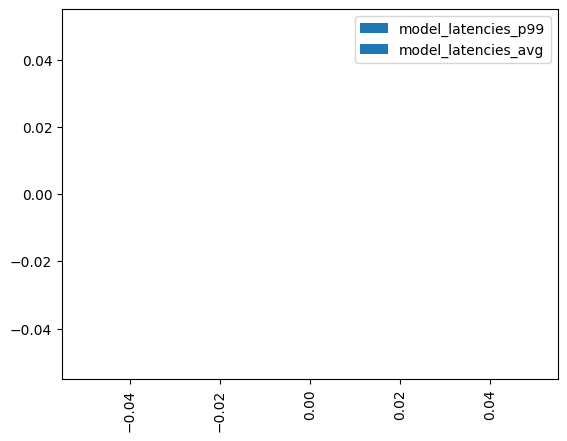

In [24]:
experiment_ids = key_config_df[
    key_config_df['model_variant'] == 'resnet152']['experiment_id'].tolist()
metadata_columns = ['model_variant', 'max_batch_size', 'cpu_request']
results_columns = ['model_latencies_p99', 'cpu_usage_count_avg', 'model_latencies_avg']
output = loader.table_maker(
    experiment_ids=experiment_ids,
    metadata_columns=metadata_columns,
    results_columns=results_columns)
display(output)
ax = output.plot.bar(x='cpu_request', y=['model_latencies_p99', 'model_latencies_avg'])
ax.set_xlabel("CPU Allocation (Cores)")
ax.set_ylabel("Latency (seconds)")